# Deep Q-Network (DQN) and Double-DQN for multiple environment
---
Implementation of a DQN & Double-DQN agent with different OpenAI Gym environments.

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import time

### 2. Instantiate the Environment and Agent

Initialize the environment.  See [`LunarLander`](https://gym.openai.com/envs/LunarLander-v2/) and [`CS221`](https://stanford-cs221.github.io/autumn2019-extra/posters/113.pdf) for more detaisl.

#### Some information about the environment from the gym homepage for LunarLander
* The lander maneuvers by engaging thrusters (with a noisy outcome) and consuming fuel.
* **State has 8 components**: horizontal and vertical position, horizontal and vertical velocity, angle and angular velocity, and left and right leg contact.
* Control agent can take **four actions** (i) do nothing, (ii) fire main engine (push up), (iii) fire left engine (push right), and (iv) fire right engine (push left)
* Vehicle starts from the top of the screen (with random initial velocity) and landing pad is always at coordinates (0,0)
* Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Firing side engine is -0.03 points each frame. Solved is 200 points. 
* Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Please see source code for details.

#### Use the following environments from OpenAI Gym:
* LunarLander
* CartPole
* Acrobat
* MountainCar

In [2]:
# LunarLander-v2 -> set the mean score value to >= 200 => good
# env = gym.make('LunarLander-v2')

# CartPole-v1 -> set the mean score value to >= 250 => works very good
env = gym.make('CartPole-v1')

# Acrobot-v1 -> set the mean score value to >= -110 => works very good
# env = gym.make('Acrobot-v1')

# Acrobot-v1 -> set the mean score value to >= -130 => works after about 4500 episodes and eps_decay=0.9995
# env = gym.make('MountainCar-v0')

env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)
# print('State shape: ', env.observation_space.shape[0])

obs_space_size = env.observation_space.shape[0]
act_space_size = env.action_space.n

State shape:  (4,)
Number of actions:  2


The neural network architecture is defined in `model.py` that maps states to action values.

The `Agent` class is defined in `dqn_agent.py` for `DQN` according to [`Mnih et al., 2015`](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) and in `double-dqn-agent` for the Double-Deep-Q-Network according [`van Hasselt et al., 2015`](https://arxiv.org/pdf/1509.06461.pdf).  

In [3]:
# Deep-Q-Network implementation
# from dqn_agent import Agent

# Doubl-Deep-Q-Network implementation
from double_dqn_agent import Agent

In [4]:
# agent = Agent(state_size=8, action_size=4, seed=0)
agent = Agent(state_size=obs_space_size, action_size=act_space_size, seed=0)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
#     print(action)
    env.render()
    time.sleep(0.05)
    state, reward, done, _ = env.step(action)
#     print('state', state)
#     print('reward', reward)
#     print('done', done)
    if done:
        break 
        
env.close()

### 3. Train the Agent with DQN

Train the agent from scratch.

Episode 100	Average Score: 21.61
Episode 200	Average Score: 15.21
Episode 300	Average Score: 14.95
Episode 400	Average Score: 13.85
Episode 500	Average Score: 13.34
Episode 600	Average Score: 16.69
Episode 700	Average Score: 20.71
Episode 800	Average Score: 119.86
Episode 888	Average Score: 200.75
Environment solved in 788 episodes!	Average Score: 200.75


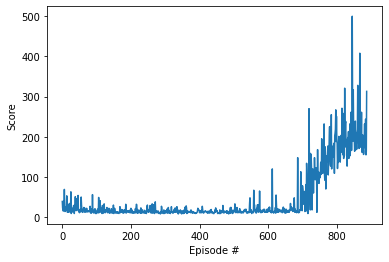

In [5]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
#             # return value(s) for debug purposes
#             ret = agent.step(state, action, reward, next_state, done)
#             if ret != None:
#                 print(ret)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

Load the trained weights from file to watch a smart agent!

In [6]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    state = env.reset()
    for j in range(400):
        action = agent.act(state)
#         print('action', action)
        env.render()
        time.sleep(0.05)
        state, reward, done, _ = env.step(action)
#         print('state', state)
#         print('reward', reward)
        if done:
            print('Steps: ', j)
            break 
            
env.close()

Steps:  251
Steps:  305
Steps:  291
Steps:  199
Steps:  261
